In [43]:
%matplotlib inline


================================================================================
02. 2D Image
================================================================================

**Suhas Somnath**

10/12/2018

**This example illustrates how a 2D grayscale image would be represented in the Universal Spectroscopy and
Imaging Data (USID) schema and stored in a Hierarchical Data Format (HDF5) file, also referred to as the h5USID file.**

This document is intended as a supplement to the explanation about the `USID data model </../data_format.html>`_

Please consider downloading this document as a Jupyter notebook using the button at the bottom of this document.

Prerequisites:
--------------
We recommend that you read about the `USID data model <../usid_model.html>`_

We will be making use of the ``pyUSID`` package at multiple places to illustrate the central point. While it is
recommended / a bonus, it is not absolutely necessary that the reader understands how the specific ``pyUSID`` functions
work or why they were used in order to understand the data representation itself.
Examples about these functions can be found in other documentation on pyUSID and the reader is encouraged to read the
supplementary documents.

Import all necessary packages
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The main packages necessary for this example are ``h5py`` and ``matplotlib`` in addition to ``pyUSID``:



In [44]:
from __future__ import print_function, division, unicode_literals
import subprocess
import sys
import os
from warnings import warn
import h5py
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])


try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    install('wget')
    import wget

# Finally import pyUSID.
try:
    import pyUSID as usid
except ImportError:
    warn('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import pyUSID as usid

Source image
-------------
For this example, we will be working with a simple grayscale image.

Download from GitHub
~~~~~~~~~~~~~~~~~~~~
As mentioned earlier, this image is available on the USID repository and can be accessed directly as well.
Here, we will simply download the file using ``wget``:



In [45]:
image_path = '../data/simulated_STEM_Image.tiff'
# image_path = 'temp.tif'
# url = 'https://raw.githubusercontent.com/pycroscopy/USID/master/data/simulated_STEM_Image.tif'
# if os.path.exists(image_path):
#     os.remove(image_path)
# _ = wget.download(url, image_path, bar=None)

More about this image
~~~~~~~~~~~~~~~~~~~~~
Lets visualize this image and learn about its original shape:



Text(0.5, 1.0, 'Image of shape: (256, 256)')

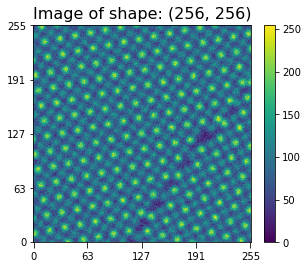

In [46]:
img_obj = Image.open(image_path)
# Convert to grayscale:
img_obj = img_obj.convert(mode="L")
orig_image = np.asarray(img_obj)

fig, axis = plt.subplots()
usid.plot_utils.plot_map(axis, orig_image, num_ticks=5)
axis.set_title('Image of shape: {}'.format(orig_image.shape))

h5USID File
-----------
Download from GitHub
~~~~~~~~~~~~~~~~~~~~~
Similarly the corresponding h5USID dataset is also available on the USID repository.
Here, we will simply download the file using ``wget``:



In [47]:
h5_path = '../data/simulated_STEM_Image.h5'
# h5_path = 'temp.h5'
# url = 'https://raw.githubusercontent.com/pycroscopy/USID/master/data/simulated_STEM_Image.h5'
# if os.path.exists(h5_path):
#     os.remove(h5_path)
# _ = wget.download(url, h5_path, bar=None)

Open the file
~~~~~~~~~~~~~
Lets open the file and look at its contents using
`pyUSID.hdf_utils.print_tree() <../../pyUSID/auto_examples/beginner/plot_hdf_utils_read.html#print-tree>`_



In [48]:
h5_file = h5py.File(h5_path, mode = 'r')
usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


Access the ``Main`` Dataset containing the image of interest
------------------------------------------------------------
Clearly, this file contains a single `Measurement` which has a single `Channel <../usid_model.html#channels>`_.
We can access the `Main Dataset <../usid_model.html#main-datasets>`_ where all the information is located in
multiple ways. Given that this file contains just a single ``Main Dataset`` we can conveniently use the
`pyUSID.hdf_utils.get_all_main() <../../pyUSID/auto_examples/beginner/plot_hdf_utils_read.html#get-all-main>`_ function.



In [49]:
h5_main = usid.hdf_utils.get_all_main(h5_file)[-1]
print(h5_main)

<HDF5 dataset "Raw_Data": shape (65536, 1), type "|u1">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Intensity (a.u.) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 256 
	Y - size: 256 
Spectroscopic Dimensions: 
	None - size: 1
Data Type:
	uint8


Here, ``h5_main`` is a `USIDataset <../../pyUSID/auto_examples/beginner/plot_usi_dataset.html>`_, which can be thought of as a supercharged
HDF5 Dataset that is not only aware of the contents of the plain ``Raw_Data`` dataset but also its links to the
`Ancillary Datasets <../usid_model.html#ancillary-datasets>`_ that make it a ``Main Dataset``.

Understanding Dimensionality
----------------------------
What is more is that the above print statement shows that this ``Main Dataset`` has two ``Position Dimensions`` -
``X`` and ``Y`` each of size ``256`` and a single ``Spectroscopic Dimension`` - ``None`` which was never varied
at each of the locations in the dataset.
Therefore, this dataset is really just a simple 2D dataset with both dimensions being position dimensions.
In other words, this dataset is just a simple 2D spatial / locations map.

The original shape of the source image was ``(256, 256)``. However, recall that USID requires all position dimensions
to be flattened along the first axis and all spectroscopic dimensions to be flattened along the second axis of the
``Main Dataset``. In other words, this means that the image needs to be represented as a ``(256 * 256, 1)`` in USID.
In USID, this shape needs to (explicitly) include a spectroscopic axis to state that a single data point was recorded
at each location.

Visualize the Main Dataset
--------------------------
Now lets visualize the contents within this ``Main Dataset`` using the ``USIDataset's`` built-in
`visualize() <../../pyUSID/auto_examples/beginner/plot_usi_dataset.html#interactive-visualization>`_ function. Clearly, this dataset is indeed
a simple 2D image



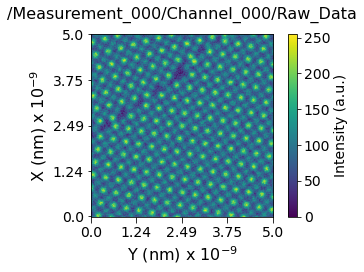

In [50]:
usid.plot_utils.use_nice_plot_params()
h5_main.visualize(num_ticks = 5);

Ancillary Datasets
------------------
As mentioned in the documentation on USID, ``Ancillary Datasets`` are required to complete the information for any
dataset. Specifically, these datasets need to provide information about the values against which measurements were
acquired, in addition to explaining the original dimensionality (2 in this case) of the original dataset. Let's look
at the ancillary datasets and see what sort of information they provide. We can access the ``Ancillary Datasets``
linked to the ``Main Dataset`` (``h5_main``) just like a property of the object.

Ancillary Position Datasets
---------------------------



In [51]:
print('Position Indices:')
print('-------------------------')
print(h5_main.h5_pos_inds)
print('\nPosition Values:')
print('-------------------------')
print(h5_main.h5_pos_vals)

Position Indices:
-------------------------
<HDF5 dataset "Position_Indices": shape (65536, 2), type "<u4">

Position Values:
-------------------------
<HDF5 dataset "Position_Values": shape (65536, 2), type "<f4">


Recall from the USID definition that the shape of the Position Ancillary datasets is ``(P, N)`` where ``N`` is the
number of Position dimensions and the ``P`` is the number of locations over which data was recorded. Here, we have
two position dimensions. Therefore ``N`` is ``2``. ``P`` matches with the first axis of the shape of ``h5_main``
which is ``65536``. Generally, there is no need to remember these rules or construct these ancillary datasets
manually since pyUSID has several functions that automatically simplify this process.

Visualize the contents of the Position Ancillary Datasets
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Notice below that there are two sets of lines, one for each dimension. The blue lines on the left-hand column
appear solid simply because this dimension (``X`` or columns) varies much faster than the other dimension (``Y`` or
rows). The first few rows of the dataset are visualized on the right-hand column.



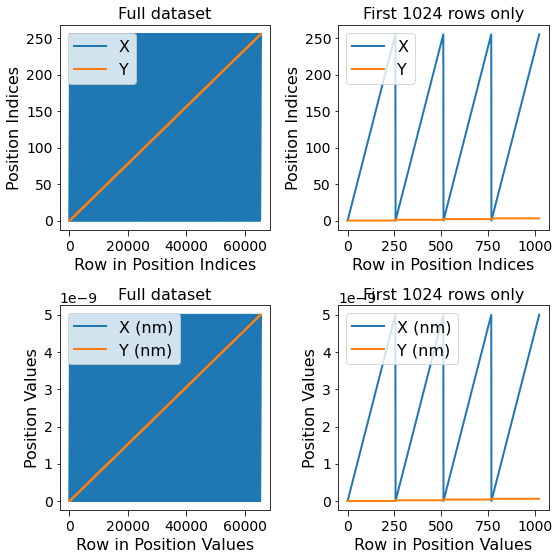

In [52]:
fig, all_axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))

for axes, h5_pos_dset, dset_name in zip(all_axes,
                                        [h5_main.h5_pos_inds, h5_main.h5_pos_vals],
                                        ['Position Indices', 'Position Values']):
    axes[0].plot(h5_pos_dset[()])
    axes[0].set_title('Full dataset')
    axes[1].set_title('First 1024 rows only')
    axes[1].plot(h5_pos_dset[:1024])
    for axis in axes.flat:
        axis.set_xlabel('Row in ' + dset_name)
        axis.set_ylabel(dset_name)
        axis.legend(h5_main.pos_dim_labels)

for axis in all_axes[1]:
    axis.legend(h5_main.pos_dim_descriptors)

fig.tight_layout();

Making sense of the visualization
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Given that the columns vary faster
than the rows means that the contents of each row of the image have been stored end-to-end in the ``Main Dataset``
as opposed to on top of each other as in the original 2D image.

Attributes associated with the Position Indices Dataset
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Just looking at the shape and values of the Position ancillary datasets does not provide all the information.
Recall that the ancillary datasets need to have some mandatory attributes like ``labels`` and ``units`` that
describe the quantity and units for each of the dimensions:



In [53]:
for key, val in usid.hdf_utils.get_attributes(h5_main.h5_pos_inds).items():
    print('{} : {}'.format(key, val))

X : <HDF5 region reference>
Y : <HDF5 region reference>
labels : ['X' 'Y']
units : ['nm' 'nm']


Ancillary Spectroscopic Datasets
--------------------------------
Given that this is a 2D image where data was not acquired as a function of some independent parameter at each
location, the spectroscopic datasets will contain bare minimum information



In [54]:
print('Spectroscopic Indices:')
print('-------------------------')
print(h5_main.h5_spec_inds)
print('containing:')
print(h5_main.h5_spec_inds[()])
print('\nSpectroscopic Values:')
print('-------------------------')
print(h5_main.h5_spec_vals)
print('containing:')
print(h5_main.h5_spec_vals[()])

Spectroscopic Indices:
-------------------------
<HDF5 dataset "Spectroscopic_Indices": shape (1, 1), type "<u4">
containing:
[[0]]

Spectroscopic Values:
-------------------------
<HDF5 dataset "Spectroscopic_Values": shape (1, 1), type "<f4">
containing:
[[1.]]


Note that as explained above, these spectroscopic datasets only contain a single value for the `fake` spectroscopic
axis over which the data was collected. Regardless of the fact that a single data poing was collected at each
location, the Spectroscopic datasets should be two dimensional in shape (one element in each axis) according the
USID rules.

Regardless of how uninformative the spectroscopic Datasets seem for this specific example, they are still necessary
for the ``Raw_Data`` dataset to be a ``Main Dataset``.

Attributes within the Spectroscopic Indices Dataset
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Again, the attributes of Spectroscopic Datasets show mandatory information about the Spectroscopic dimensions such as
the quantity (``labels``) and ``units``:



In [55]:
for key, val in usid.hdf_utils.get_attributes(h5_main.h5_spec_inds).items():
    print('{} : {}'.format(key, val))

None : <HDF5 region reference>
labels : ['None']
units : ['a.u.']


Attempting to visualize the first few rows of the image manually
----------------------------------------------------------------



In [56]:
print(h5_main.pos_dim_labels)
print(h5_main.pos_dim_sizes)

['X', 'Y']
[256, 256]


In [57]:
rows_to_read = 50
num_cols = h5_main.pos_dim_sizes[1]
first_few_rows_1D = h5_main[: rows_to_read * num_cols, :]
print(first_few_rows_1D.shape)

(12800, 1)


In [58]:
first_few_rows_2D = np.reshape(first_few_rows_1D, (rows_to_read, num_cols))
print(first_few_rows_2D.shape)

(50, 256)


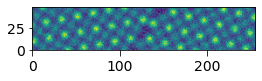

In [59]:
fig, axis = plt.subplots(figsize=(4, 1))
axis.imshow(first_few_rows_2D, origin='lower')

Clean up
--------
Finally lets close the HDF5 file.



In [60]:
h5_file.close()

Here, we will even delete the HDF5 file in addition to the source 2D image. Please comment out the following lines if
you want to look at the HDF5 file using software like HDFView or work with the 2D image



In [61]:
# os.remove(h5_path)
# os.remove(image_path)